In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err,axis=0) / m
    # 시그모이드 함수까지 그래디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m # 행 방향으로 더하기
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self,z):
    z = np.clip(z,-100, None)
    a = 1 / (1+np.exp(-z))
    return a

  def softmax(self,z):
    z = np.clip(z,-100, None)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1,1) # 열방향 합산 후 열벡터로 변환

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0,1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1,(self.units, n_classes))
    self.b2 = np.zeros(n_classes)


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    # epochs iteration
    for i in range(epochs):
      loss = 0
      print('.', end='')
      # 제너레이터 함수에서 반환한 미니 배치를 순환
      for x_batch, y_batch in self.gen_batch(x,y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실
        loss += np.sum(-y_batch*np.log(a))
      # 규제 손실과 합산 후 losses에 추가
      self.losses.append((loss + self.reg_loss())/len(x))
      # 검증 세트에 대한 손실을 계산
      self.update_val_loss(x_val, y_val)

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexs = np.random.permutation(np.arange(len(x)))
    x = x[indexs]
    y = y[indexs]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1)/m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2)/m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad

    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  # hidden layer and output layer -> regularization
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
    self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))


  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10) # 크로스 엔트로피 손실
    # 크로스 엔트로피 손실+ 규제 손실 -> 리스트에 추가한다.
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss())/len(y_val))


In [ ]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [ ]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


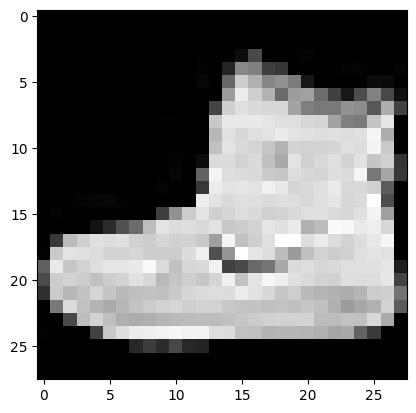

In [ ]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [ ]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [ ]:
print(class_names[y_train_all[0]])

앵클부츠


In [ ]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2, random_state=42)
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [ ]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [ ]:
x_train = x_train/255
x_val = x_val/255

In [ ]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [ ]:
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)


........................................

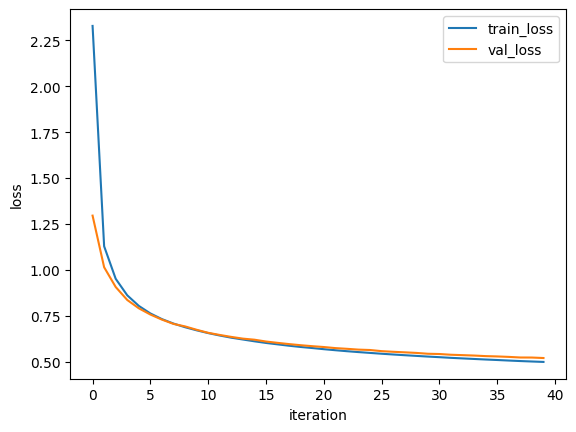

In [ ]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
print(fc.score(x_val, y_val_encoded))

0.81475


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [ ]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,))) # 은닉층 유닛 개수 100개
model.add(Dense(10, activation='softmax')) #  출력층 유닛개수 10개

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5073 - loss: 1.7460 - val_accuracy: 0.7326 - val_loss: 0.9692
Epoch 2/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7364 - loss: 0.9026 - val_accuracy: 0.7672 - val_loss: 0.7485
Epoch 3/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7631 - loss: 0.7287 - val_accuracy: 0.7807 - val_loss: 0.6593
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7803 - loss: 0.6566 - val_accuracy: 0.7949 - val_loss: 0.6087
Epoch 5/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7921 - loss: 0.6076 - val_accuracy: 0.8041 - val_loss: 0.5747
Epoch 6/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8034 - loss: 0.5718 - val_accuracy: 0.8117 - val_loss: 0.5474
Epoch 7/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8106 - loss: 0.5523 - val_accuracy: 0.8175 - val_loss: 0.5300
Epoch 8/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8107 - loss: 0.5418 -

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


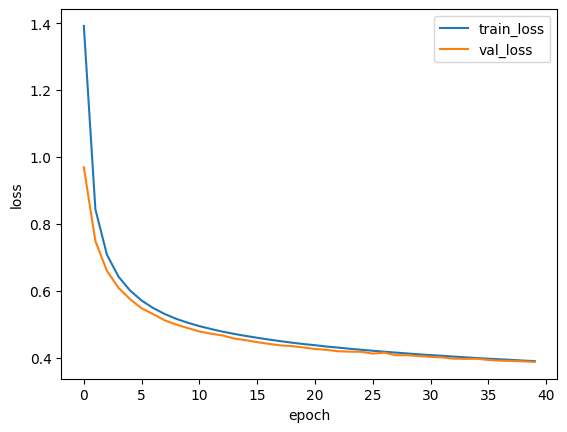

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

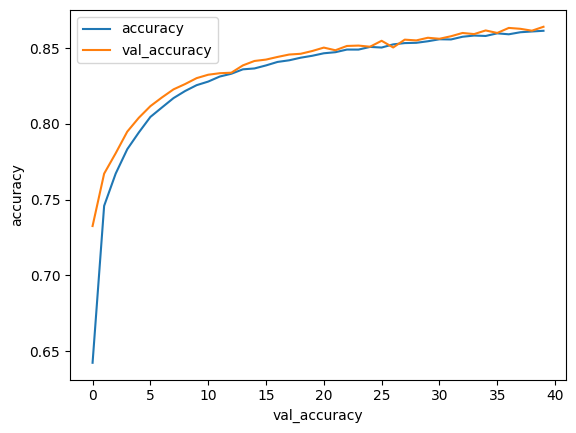

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('val_accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8641666769981384
